![](https://hacks-ai.ru/_next/static/media/header-logo.c7e8f395.svg)

На данном кейсе вам необходимо детектировать несколько видов нарушений ПДД, а именно :

* 'Статья 12.16. часть 1 Несоблюдение требований, предписанных дорожными знаками или разметкой проезжей части дороги',
* 'Статья 12.12 часть 2 1. невыполнение требования ПДД об остановке перед стоп-линией, обозначенной дорожными знаками или разметкой проезжей части дороги, при запрещающем сигнале светофора или запрещающем жесте регулировщика',
* 'Статья 12.15 часть 4 Выезд в нарушение правил дорожного движения на полосу, предназначенную для встречного движения, при объезде препятствия, либо на трамвайные пути встречного направления, за исключением случаев, предусмотренных частью 3 настоящей статьи',
* 'Статья 12.16 часть 2 Поворот налево или разворот в нарушение требований, предписанных дорожными знаками или разметкой проезжей части дороги',
* 'Статья 12.17 часть 1.1 и 1.2. движение транспортных средств по полосе для маршрутных транспортных средств или остановка на указанной полосе в нарушение Правил дорожного движения'

При создании baseline остановимся на правиле "Статья 12.16. часть 1", так или иначе остальные правила также задействуют разметку дороги, так что будет полезно научить алгоритм работать с ней.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Создание функций

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


def img_detect_color(image, show=False):
    """
    Функция для выделения светлых (приблизительно белых) областей на изображении.

    Параметры:
    image (numpy.ndarray): Входное изображение.
    show (bool): Если True, отображает результат обработки.

    Возвращает:
    numpy.ndarray: Изображение, на котором выделены светлые области.
    """

    # Создаем копию изображения для обработки
    color_select = np.copy(image)

    # Задаем пороговые значения для цветовых каналов (R, G, B)
    red_threshold = 130
    green_threshold = 130
    blue_threshold = 120

    # Создаем маску для пикселей, не соответствующих пороговым значениям
    # Пиксели, значения цветовых каналов которых ниже пороговых значений, будут отфильтрованы
    thresholds = (image[:, :, 0] < red_threshold) | \
                 (image[:, :, 1] < green_threshold) | \
                 (image[:, :, 2] < blue_threshold)

    # Применяем маску: пиксели, не соответствующие пороговым значениям, окрашиваются в черный цвет
    color_select[thresholds] = [0, 0, 0]

    # Отображаем результат, если параметр show установлен в True
    if show:
        plt.imshow(color_select)
        plt.title("Выделение +- белого цвета")
        plt.show()

    # Возвращаем изображение с выделенными светлыми областями
    return color_select


def mask_area_on_image(image, show=False):
    """
    Функция для выделения области дороги на изображении с наложением маски.

    Параметры:
    image (numpy.ndarray): Входное изображение.
    show (bool): Если True, отображает результат обработки и границу области интереса.

    Возвращает:
    numpy.ndarray: Изображение с выделенной областью.
    """

    # Создаем пустую маску того же размера, что и изображение (трехканальную для цветного изображения)
    mask = np.zeros_like(image)
    height, width, _ = mask.shape  # Получаем высоту, ширину и количество каналов изображения

    # Определяем координаты полигона для выделения области интереса (в данном случае - дороги перед машиной)
    # polygon - массив с координатами углового полигона (ROI)
    polygon = np.array([[
        (int(width * 0.4), height),          # Левый нижний угол
        (int(width * 0.6), height),          # Правый нижний угол
        (int(width * 0.6), int(height * 0.7)),  # Правый верхний угол
        (int(width * 0.4), int(height * 0.7))   # Левый верхний угол
    ]], np.int32)

    # Заполняем маску полигоном белого цвета (255, 255, 255) для трехканального изображения
    cv2.fillPoly(mask, polygon, (255, 255, 255))

    # Применяем маску к изображению с помощью побитового И, оставляя только область в форме полигона
    masked_image = cv2.bitwise_and(image, mask)

    # Отображаем результат, если параметр show установлен в True
    if show:
        # Создаем копию изображения с наложенной маской для добавления границы
        image_with_border = masked_image.copy()

        # Наносим красный контур на границы полигона
        cv2.polylines(image_with_border, [polygon], isClosed=True, color=(255, 0, 0), thickness=1)

        # Отображаем изображение с наложенной маской и красной границей
        plt.imshow(image_with_border)
        plt.title("Выделение региона дороги на изображении")
        plt.show()

    # Возвращаем изображение, на которое наложена маска
    return masked_image



def lines_detect(image, show=False):
    """
    Функция для обнаружения линий на изображении с использованием Canny edge detection.

    Параметры:
    image (numpy.ndarray): Входное изображение.
    show (bool): Если True, отображает результат обработки.

    Возвращает:
    numpy.ndarray: Изображение с выделенными границами.
    """

    # Преобразуем изображение в оттенки серого, так как алгоритм Canny работает с монохромными изображениями
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Применяем размытие для уменьшения шума на изображении и сглаживания переходов
    # Используется фильтр Гаусса с ядром 5x5
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Применяем оператор Canny для выделения границ
    # Первый и второй параметры - пороговые значения для градиента (нижний и верхний)
    edges = cv2.Canny(blur, 30, 100)  # 30 и 100 - пороговые значения

    # Отображаем результат, если параметр show установлен в True
    if show:
        # Отображаем изображение с выделенными линиями
        plt.imshow(edges, cmap='gray')
        plt.title("Выделение линий")
        plt.show()

    # Возвращаем изображение с выделенными границами
    return edges


def detect_road_marking(base_image, image, show=False):
    """
    Функция для обнаружения дорожной разметки на изображении с использованием Hough Line Transform.

    Параметры:
    base_image (numpy.ndarray): Исходное изображение, на которое будут нанесены обнаруженные линии.
    image (numpy.ndarray): Обработанное изображение (например, после edge detection), на котором ищем линии.
    show (bool): Если True, отображает результат обработки.

    Возвращает:
    list: Список обнаруженных линий (или пустой список, если линии не обнаружены).
    """

    # Задаем параметры Hough Line Transform
    threshold_value = 65  # Пороговое значение для минимального количества пересечений для обнаружения линии
    min_line_length = 60  # Минимальная длина линии, ниже которой линия не будет детектироваться
    max_line_gap = 50  # Максимальное расстояние между отрезками, при котором они считаются одной линией

    # Выполняем поиск линий с использованием метода HoughLinesP
    lines = cv2.HoughLinesP(image, rho=1, theta=np.pi / 180,
                            threshold=threshold_value,
                            minLineLength=min_line_length,
                            maxLineGap=max_line_gap)

    # Отображаем результат, если параметр show установлен в True
    if show:
        # Создаем пустое изображение для отрисовки обнаруженных линий
        line_image = np.zeros_like(base_image)

        # Проверяем, есть ли найденные линии
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]  # Извлекаем координаты начала и конца линии
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)  # Рисуем линию зеленым цветом

        # Накладываем изображение с линиями на исходный кадр для отображения результатов
        combined_image = cv2.addWeighted(base_image, 0.8, line_image, 1, 0)

        # Отображаем изображение с выделенной дорожной разметкой
        plt.imshow(combined_image)
        plt.title("Выделение дорожной разметки")
        plt.show()

    # Возвращаем найденные линии или пустой список, если линии не обнаружены
    if lines is not None:
        return lines
    else:
        return []

import numpy as np

# Функция для вычисления длины линии
def line_length(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def does_line_intersect_zone(x1, y1, x2, y2, zone_start, zone_end, height):
    """
    Функция для проверки, пересекает ли линия заданную зону на изображении.

    Параметры:
    x1, y1 (int): Координаты начала линии.
    x2, y2 (int): Координаты конца линии.
    zone_start (int): Начальная граница зоны по оси X.
    zone_end (int): Конечная граница зоны по оси X.
    height (int): Высота изображения (для проверки вертикальных границ зоны).

    Возвращает:
    bool: True, если линия пересекает зону; иначе False.
    """

    # Проверяем, попадает ли хотя бы одна из конечных точек линии в зону
    # Если x-координата начала или конца линии находится между zone_start и zone_end, то линия пересекает зону
    if (zone_start <= x1 <= zone_end) or (zone_start <= x2 <= zone_end):
        return True

    # Если конечные точки линии не попали в зону, проверяем пересечение линии с границами зоны
    # Вычисляем коэффициенты уравнения линии Ax + By + C = 0
    A = y2 - y1  # Разница координат Y
    B = x1 - x2  # Разница координат X
    C = (x2 - x1) * y1 - (y2 - y1) * x1  # Свободный член уравнения

    # Рассчитываем точки пересечения линии с вертикальными границами зоны
    # Если линия пересекает зону на уровне zone_start
    y_start = (-A * zone_start - C) / B if B != 0 else None  # Координата Y пересечения с границей zone_start

    # Если линия пересекает зону на уровне zone_end
    y_end = (-A * zone_end - C) / B if B != 0 else None  # Координата Y пересечения с границей zone_end

    # Проверяем, находится ли точка пересечения в пределах изображения по вертикали (от 0 до height)
    if y_start is not None and (0 <= y_start <= height):
        return True
    if y_end is not None and (0 <= y_end <= height):
        return True

    # Если ни одна из проверок не вернула True, линия не пересекает зону
    return False


def does_center_intersect_line_center(x1, y1, x2, y2, image_center_x):
    """
    Функция для проверки, пересекает ли центр изображения центральную часть линии.

    Параметры:
    x1, y1 (int): Координаты начала линии.
    x2, y2 (int): Координаты конца линии.
    image_center_x (int): X-координата центра изображения.

    Возвращает:
    bool: True, если центр изображения пересекает центральную часть линии; иначе False.
    """

    # Находим среднюю точку линии
    mid_x = (x1 + x2) / 2  # X-координата средней точки
    mid_y = (y1 + y2) / 2  # Y-координата средней точки (не используется в дальнейшем)

    # Вычисляем длину линии
    line_len = line_length(x1, y1, x2, y2)  # Вызываем функцию для вычисления длины линии
    offset = 0.2 * line_len  # 20% от длины линии (10% в каждую сторону от средней точки)

    # Определяем границы центральной части линии по оси X
    center_start_x = mid_x - offset  # Левая граница центральной части линии
    center_end_x = mid_x + offset    # Правая граница центральной части линии

    # Проверяем, пересекает ли центр изображения эту центральную часть линии по оси X
    return center_start_x <= image_center_x <= center_end_x  # Возвращает True или False


def line_crossing_check(lines, image, min_len_line=60, ignore_horizontal=True, verbose=False):
    """
    Функция для проверки, пересекает ли обнаруженные линии центральную часть изображения.

    Параметры:
    lines (list): Список обнаруженных линий.
    image (numpy.ndarray): Изображение, на котором проводим проверку.
    min_len_line (int): Минимальная длина линии для рассмотрения.
    ignore_horizontal (bool): Если True, игнорирует почти горизонтальные линии.
    verbose (bool): Если True, выводит дополнительную информацию о пересекающих линиях.

    Возвращает:
    bool: True, если найдена пересекающая линия; иначе False.
    """

    # Получаем высоту и ширину изображения
    height, width, _ = image.shape

    # Определяем границы зоны 10% по ширине
    zone_width = width * 0.1  # Ширина зоны в 10% от ширины изображения
    zone_start = (width / 2) - (zone_width / 2)  # Левая граница зоны
    zone_end = (width / 2) + (zone_width / 2)    # Правая граница зоны
    image_center_x = width / 2  # X-координата центра изображения

    # Если список линий пустой, возвращаем False
    if len(lines) == 0:
        return False

    # Проверка на количество линий, чтобы избежать шума
    if len(lines) > 20:
        return False  # Если слишком много линий, возвращаем False

    # Обрабатываем каждую линию
    for line in lines:
        x1, y1, x2, y2 = line[0]  # Извлечение координат начала и конца линии
        line_len = line_length(x1, y1, x2, y2)  # Вычисление длины линии

        # Проверяем, пересекает ли линия зону и центральную часть изображения
        intersects_zone = does_line_intersect_zone(x1, y1, x2, y2, zone_start, zone_end, height)
        center_intersects_line_center = does_center_intersect_line_center(x1, y1, x2, y2, image_center_x)

        # Определяем, какая из точек является левой нижней
        if (y1 > y2) or (y1 == y2 and x1 < x2):
            left_x, left_y = x1, y1  # Если первая точка ниже, она считается левой нижней
        else:
            left_x, left_y = x2, y2  # Иначе считается, что второй точка - левая нижняя

        # Проверка наклона линии (игнорируем горизонтальные линии, если указано)
        if ignore_horizontal:
            if abs(y2 - y1) < height * 0.2:  # Если линия почти горизонтальная
                continue  # Переходим к следующей линии

        # Условие для проверки длины, пересечения зоны и центральной части линии
        if center_intersects_line_center:
            if verbose:
                # Выводим информацию о пересекающей линии, если verbose=True
                print(f"Line with length {int(line_len)} intersects the 10% center zone, "
                      f"the lower-left point is right of the center, and "
                      f"the 20% center section of the line intersects the image center.")
            return True  # Если условия выполнены, возвращаем True

    return False  # Если не нашли подходящих линий, возвращаем False


#Анализ изображения

Аналих строится на нескольких этапах. Обработаем одно изоражение и визуализируем результат на каждом этапе

In [ ]:
!wget https://i.postimg.cc/rmP7YQ73/frame-sample.png

--2024-10-30 19:55:39--  https://i.postimg.cc/rmP7YQ73/frame-sample.png
Resolving i.postimg.cc (i.postimg.cc)... 104.238.220.6
Connecting to i.postimg.cc (i.postimg.cc)|104.238.220.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158689 (155K) [image/png]
Saving to: ‘frame-sample.png.2’

frame-sample.png.2  100%[===================>] 154.97K   331KB/s    in 0.5s    

2024-10-30 19:55:40 (331 KB/s) - ‘frame-sample.png.2’ saved [158689/158689]



In [ ]:
base_image = cv2.imread('/content/frame-sample.png')
base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)
image = base_image

Отображение изображения

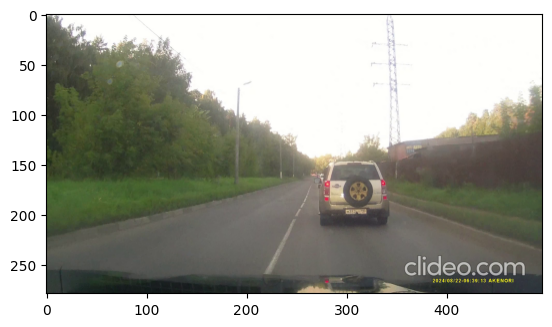

In [ ]:
plt.imshow(base_image)

Выделяем более-менее белый цвет

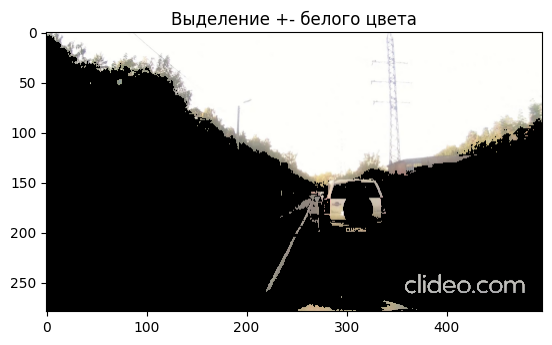

In [ ]:
image = img_detect_color(image, show = True)

Фокусируемся только на одной части изображения (дороге перед машиной)

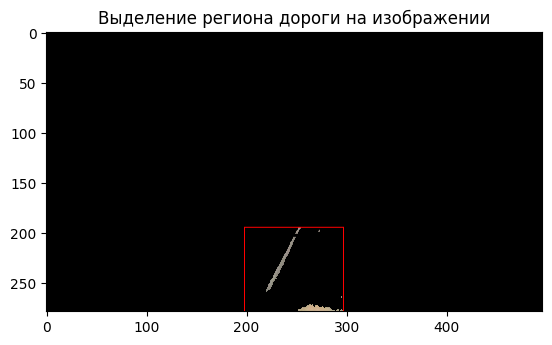

In [ ]:
image = mask_area_on_image(image, show = True)

Выделяем линии объектов на изображении

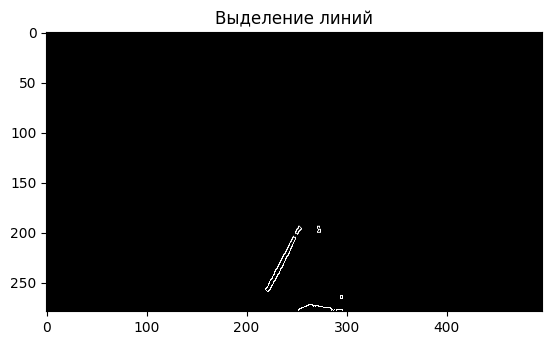

In [ ]:
image = lines_detect(image, show = True)

Находим линии дорожной разметки

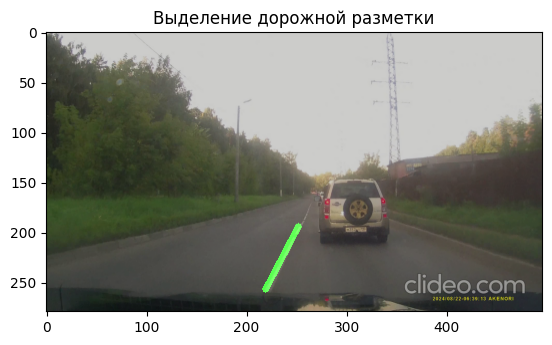

In [ ]:
lines = detect_road_marking(base_image, image, show=True)

Найденые линии

In [ ]:
lines

array([[[219, 257, 252, 194]]], dtype=int32)

Смотрим было ли нарушено правило. В бейслайне нарушением считается пересечение линии разметки центром кадра (так мы предполагаем, что машина держит направление за линию разметки).

In [ ]:
line_crossing_check(lines, base_image, min_len_line = 100, verbose = False)

True

#Анализ видео

In [ ]:
#Общий конвейер для вызова функций
def process_frame(frame, show = False):
  image = img_detect_color(frame, show)
  image = mask_area_on_image(image, show)
  image = lines_detect(image, show)
  lines = detect_road_marking(frame, image, show)
  violation = line_crossing_check(lines, frame, min_len_line = 60)
  return violation

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def main_analise(video_path, frames_to_take=50, show=False, debug_sec=[]):
    """
    Функция для анализа кадров из видео на предмет нарушений правил.

    Параметры:
    video_path (str): Путь к видеофайлу.
    frames_to_take (int): Количество кадров для анализа.
    show (bool): Если True, отображает текущий кадр.
    debug_sec (list): Список секунд, на которых нужно показать кадры и вывести отладочную информацию.

    Возвращает:
    list: Список результатов анализа и кадры с нарушениями.
    """

    result_analise = []  # Список для хранения результатов анализа
    violation_frames = []  # Список для хранения кадров с нарушениями

    # Открываем видеофайл
    cap = cv2.VideoCapture(video_path)

    # Получаем параметры видео
    fps = cap.get(cv2.CAP_PROP_FPS)  # Частота кадров
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Ширина кадра
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Высота кадра
    count_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Общее количество кадров
    duration = count_frame // fps  # Длительность видео в секундах
    freq = max(1, count_frame // frames_to_take)  # Частота выборки кадров (не менее 1)
    print(f"Частота выборки кадров: {freq}")

    success, frame = cap.read()  # Читаем первый кадр
    count = 0  # Счетчик кадров

    # Инициализируем tqdm для отслеживания прогресса
    with tqdm(total=count_frame // freq, desc="Processing frames") as pbar:
        while success:
            if count % freq == 0:  # Обрабатываем только выбранные кадры
                time_sec = count // fps  # Вычисляем текущую секунду видео
                if time_sec in debug_sec:
                    show = True  # Включаем отображение, если текущая секунда в списке отладки

                # Обрабатываем кадр (преобразуем цветовую схему)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                if show:
                    plt.imshow(frame)  # Отображаем текущий кадр
                    plt.title("Current Frame")
                    plt.show()

                # Вызываем функцию для обработки кадра
                violation = process_frame(frame, show=show)

                # Сохраняем результат анализа (нарушение и время)
                result_analise.append([violation, time_sec])

                if violation:
                    violation_frames.append(frame)  # Сохраняем кадр с нарушением

                # Обновляем прогресс-бар
                pbar.update(1)

                if time_sec in debug_sec:
                    show = False  # Отключаем отображение после вывода отладки
                    print(f'\n\nОбработка кадра на {time_sec} секунде')
                    print('Правило нарушено' if violation else 'Правило не нарушено')
                    print('----------------------------')

            success, frame = cap.read()  # Читаем следующий кадр
            count += 1  # Увеличиваем счетчик

    cap.release()  # Закрываем видеофайл
    cv2.destroyAllWindows()  # Закрываем все окна OpenCV
    return [result_analise, violation_frames]  # Возвращаем результаты анализа и кадры с нарушениями



В функцию подается несколько параметров :
* frames_to_take - строго фиксированное число анализируемых кадров в видео (например, если подается видео длиной 500 сек, а frames_to_take =500, то будет проанализировано по одному кадру с каждой секунды видео)

* show - при значении True будет отображать результат работы каждого этапа для каждого кадра

* debug_sec - массив из секунд, для соответствующий кадров из видео будет включен параметр show. Например, если debug_sec = [19,42], то при обработке видео для кадров на 19 и 42 секунд видео будет отображены результаты каждого из отработавших этапов обработки.

In [ ]:
result_analise, violation_frames = main_analise('.../akn00006_fqGg6dtL.mov', frames_to_take = 500, show = False, debug_sec = [])

Частота выборки кадров: 17


Processing frames: 529it [02:38,  3.33it/s]


Массив вида : нарушил ли водитель пдд на кадре? - секунда в видео этого кадра

In [ ]:
result_analise

[[False, 0.0],
 [False, 0.0],
 [False, 1.0],
 [False, 1.0],
 [False, 2.0],
 [False, 2.0],
 [False, 3.0],
 [False, 3.0],
 [False, 4.0],
 [False, 5.0],
 [False, 5.0],
 [False, 6.0],
 [False, 6.0],
 [False, 7.0],
 [False, 7.0],
 [False, 8.0],
 [False, 9.0],
 [False, 9.0],
 [False, 10.0],
 [False, 10.0],
 [False, 11.0],
 [False, 11.0],
 [False, 12.0],
 [False, 13.0],
 [False, 13.0],
 [False, 14.0],
 [False, 14.0],
 [False, 15.0],
 [False, 15.0],
 [False, 16.0],
 [False, 17.0],
 [False, 17.0],
 [False, 18.0],
 [False, 18.0],
 [False, 19.0],
 [True, 19.0],
 [False, 20.0],
 [False, 20.0],
 [False, 21.0],
 [False, 22.0],
 [False, 22.0],
 [False, 23.0],
 [False, 23.0],
 [False, 24.0],
 [False, 24.0],
 [False, 25.0],
 [False, 26.0],
 [False, 26.0],
 [False, 27.0],
 [False, 27.0],
 [False, 28.0],
 [False, 28.0],
 [False, 29.0],
 [False, 30.0],
 [False, 30.0],
 [False, 31.0],
 [False, 31.0],
 [False, 32.0],
 [False, 32.0],
 [False, 33.0],
 [False, 34.0],
 [False, 34.0],
 [False, 35.0],
 [False, 35

Отображение всех кадров, где было нарушено пдд (baseline находит только нарушения правила по Статье 12.16. часть 1)

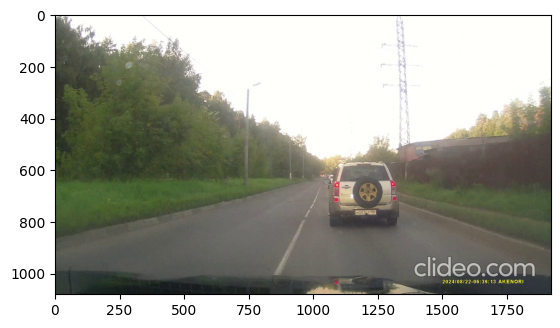

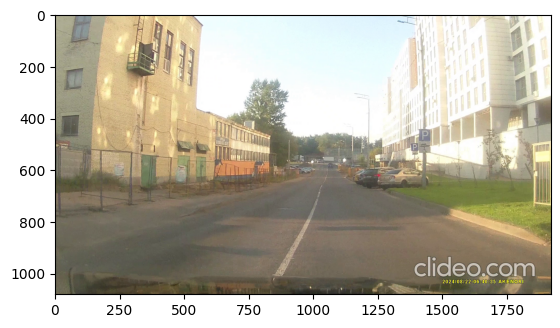

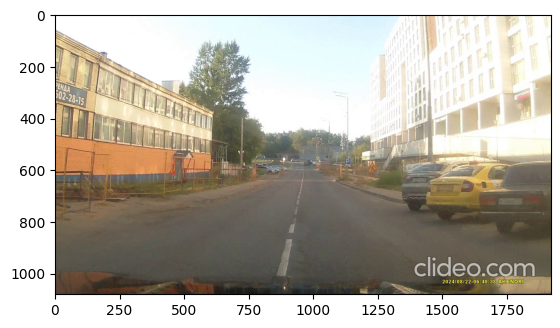

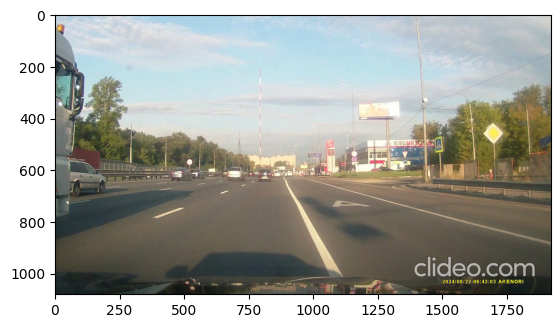

In [ ]:
for img in violation_frames:
  plt.imshow(img)
  plt.show()

#Советы

Для улучшения работы алгоритма можете попробовать :
1. Настроить алгоритм так, чтобы он не считал пунктирные линии разметки за одну линию, для этого поэкспериментируйте с параметрами в функции `detect_road_marking`. Также поменяйте параметр `min_len_line` в функции `line_crossing_check
2. Убрать шум (все, что не является дорожной разметкой) с шага выделя более-менее белого цвета (функция  `img_detect_color`). Сейчас эта проблема решается с помощью обрезания лишней части изображения (и с помощью проверки `len(lines) > 20` в функции `line_crossing_check`) , но она не всегда помогает т.к на самой дороге тоже может быть что-то яркое, кроме разметки.
3. Попробуйте увеличить кол-во обрабатываемых кадров для того, чтобы не пропустить нарушения.
4. При двойной детекции одного и того же нарушения объединяйте результаты, чтобы улучшить значения по метрике.
5. Попробуйте поменять полигон в функции  `mask_area_on_image`, с помощью этого вы можите уменьшить или увеличить часть изображения из которой будут извлекаться линии.
6. Также важно настроить алгоритм и под другие правила (в тестовом датасете будут все правила).

Для ускорения работы алгоритма можете попробовать :
1. Уменьшить разрешение кадров.
